In [1]:
%%capture
from re import sub
from pandas import DataFrame, ExcelWriter
from datetime import datetime

from sys import path 
path.insert(0, '../static')

from active import actif_served as AGYW_ACTIF

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

date_du_jour = datetime.today().strftime("%d_%m_%Y")

In [2]:
AGYW_ACTIF.dtypes

id_patient                                               int64
id_parenting_group                                     float64
departement                                             object
commune                                                 object
nbre_pres_for_inter                                      int16
nbre_parenting_coupe_present                             int16
has_comdom_topic                                        object
has_preventive_vbg                                      object
number_of_condoms_sensibilize                            int16
number_condoms_sensibilization_date_in_the_interval      int16
number_condoms_reception_in_the_interval                 int16
number_test_date_in_the_interval                         int16
test_results                                            object
number_vbg_treatment_date_in_the_interval                int16
number_gynecological_care_date_in_the_interval           int16
number_prep_initiation_date_in_the_interval            

In [3]:
pipo = list(AGYW_ACTIF.month_in_program_range.unique())
pipo.append("Total")
sorted(list(AGYW_ACTIF.age_range.unique())[0:3])
sorted(pipo)

['10-14', '15-19', '20-24']

['0-6 months', '07-12 months', '13-24 months', '25+ months', 'Total']

In [4]:
list(AGYW_ACTIF.commune.unique())

['Milot',
 'Cap-Haïtien',
 'Dessalines',
 'Liancourt',
 'Verrettes',
 'Delmas',
 "Petite Rivière de l'Artibonite",
 'Kenscoff',
 'Pétionville',
 'Gressier',
 'Tabarre',
 'Port-au-Prince',
 'Grande Saline',
 'Desdunes',
 'Montrouis',
 'Saint-Marc',
 'Limonade',
 'La Chapelle',
 'Plaine-du-Nord',
 'Quartier-Morin',
 'Carrefour']

# Indicator

In [5]:
class AgywPrev:
    """A class with properties and methods given the results of the indicator AGYW_PREV DATIM"""
    __who_am_I = "DATIM"
    __datim1_title = "Number of individual AGYW that have fully completed the entire DREAMS primary package of services/interventions but no additional services/interventions."
    __datim2_title = "Number of individual AGYW that have fully completed the entire DREAMS primary package of services/interventions AND at least one secondary service/intervention."
    __datim3_title = "Number of individual AGYW that have completed at least one DREAMS service/intervention but not the full primary package."
    __datim4_title = "Number of AGYW that have started a DREAMS service/intervention but have not yet completed it."

    def __repr__(self):
        return f"<AgywPrev {self.__i_am}>"

    def __str__(self):
        return f"<AgywPrev {self.__i_am}>"

    @classmethod
    def datim_titleI(cls):
        return cls.__datim1_title

    @classmethod
    def datim_titleII(cls):
        return cls.__datim2_title

    @classmethod
    def datim_titleIII(cls):
        return cls.__datim3_title

    @classmethod
    def datim_titleIV(cls):
        return cls.__datim4_title

    def __init__(self, commune=None):
        self.__commune = commune
        self.__i_am = f"{AgywPrev.__who_am_I}"
        self.__data = AGYW_ACTIF
        self. __total_mastersheet = self.__data.id_patient.count()
        if self.__commune == None:
            self.__dreams_valid = self.__data[(self.__data.age_range != "not_valid_age") & (
                self.__data.age_range != "25-29")]
        else:
            self.__dreams_valid = self.__data[(self.__data.age_range != "not_valid_age") & (
                self.__data.age_range != "25-29") & (self.__data.commune == f"{self.__commune}")]
        self.__total_dreams_valid = self.__dreams_valid.id_patient.count()
        self.__dreams_valid["primary_only"] = self.__dreams_valid.apply(
            lambda df: self.__primFunc(df), axis=1)
        self.__dreams_valid["primary_and_OneSecondary_services"] = self.__dreams_valid.apply(
            lambda df: self.__primLeastOneSecFunc(df), axis=1)
        self.__dreams_valid["completed_one_service"] = self.__dreams_valid.apply(
            lambda df: self.__primPartFunc(df), axis=1)
        self.__dreams_valid["has_started_one_service"] = self.__dreams_valid.apply(
            lambda df: self.__hasStartedFunc(df), axis=1)
        self.__agyw_prevI = self.__dreams_valid[self.__dreams_valid.primary_only ==
                                                "full_primary_only"]
        self.__agyw_prevII = self.__dreams_valid[self.__dreams_valid.primary_and_OneSecondary_services ==
                                                 "full_primary_leastOneSecondary"]
        self.__agyw_prevIII = self.__dreams_valid[self.__dreams_valid.completed_one_service ==
                                                  "primary_part_services"]
        self.__agyw_prevIV = self.__dreams_valid[self.__dreams_valid.has_started_one_service == "yes"]
        self.__agyw_prevI_total = self.__agyw_prevI.id_patient.count()
        self.__agyw_prevII_total = self.__agyw_prevII.id_patient.count()
        self.__agyw_prevIII_total = self.__agyw_prevIII.id_patient.count()
        self.__agyw_prevIV_total = self.__agyw_prevIV.id_patient.count()
        self.__total_datim = self.__agyw_prevI_total + self.__agyw_prevII_total + \
            self.__agyw_prevIII_total + self.__agyw_prevIV_total

    @property
    def who_am_i(self):
        return self.__i_am

    @property
    def data_mastersheet(self):
        return self.__data

    @property
    def data_dreams_valid(self):
        return self.__dreams_valid

    @property
    def total_mastersheet(self):
        return self.__total_mastersheet

    @property
    def total_dreams_valid(self):
        return self.__total_dreams_valid

    def __primFunc(self, df):
        if (df.ps_1014 == "primary" and df.hts == "no" and df.prep == "no" and df.condom == "no" and df.post_violence_care == "no" and df.socioeco_app == "no" and df.parenting == "no" and df.contraceptive == "no"):
            return "full_primary_only"
        elif (df.ps_1519 == "primary" and df.hts == "no" and df.prep == "no" and df.post_violence_care == "no" and df.socioeco_app == "no" and df.parenting == "no" and df.contraceptive == "no"):
            return "full_primary_only"
        elif (df.ps_2024 == "primary" and df.hts == "no" and df.prep == "no" and df.post_violence_care == "no" and df.socioeco_app == "no" and df.parenting == "no" and df.contraceptive == "no"):
            return "full_primary_only"
        else:
            return "invalid"

    def __primLeastOneSecFunc(self, df):
        if (df.ps_1014 == "primary") and (df.hts == "yes" or df.prep == "yes" or df.condom == "yes" or df.post_violence_care == "yes" or df.socioeco_app == "yes" or df.parenting == "yes" or df.contraceptive == "yes"):
            return "full_primary_leastOneSecondary"
        elif (df.ps_1519 == "primary") and (df.hts == "yes" or df.prep == "yes" or df.post_violence_care == "yes" or df.socioeco_app == "yes" or df.parenting == "yes" or df.contraceptive == "yes"):
            return "full_primary_leastOneSecondary"
        elif (df.ps_2024 == "primary") and (df.hts == "yes" or df.prep == "yes" or df.post_violence_care == "yes" or df.socioeco_app == "yes" or df.parenting == "yes" or df.contraceptive == "yes"):
            return "full_primary_leastOneSecondary"
        else:
            return "invalid"

    def __primPartFunc(self, df):
        if (df.age_range == "10-14") and (df.primary_only == "invalid") and (df.primary_and_OneSecondary_services == 'invalid') and ((df.hts == "yes" or df.prep == "yes" or df.condom == "yes" or df.post_violence_care == "yes" or df.socioeco_app == "yes" or df.parenting == "yes" or df.contraceptive == "yes")):
            return "primary_part_services"
        elif (df.age_range == "15-19") and (df.primary_only == "invalid") and (df.primary_and_OneSecondary_services == 'invalid') and (df.curriculum == "yes" or df.condom == "yes" or df.hts == "yes" or df.prep == "yes" or df.post_violence_care == "yes" or df.socioeco_app == "yes" or df.parenting == "yes" or df.contraceptive == "yes"):
            return "primary_part_services"
        elif (df.age_range == "20-24") and (df.primary_only == "invalid") and (df.primary_and_OneSecondary_services == 'invalid') and ((df.curriculum == "yes" or df.condom == "yes" or df.hts == "yes" or df.prep == "yes" or df.post_violence_care == "yes" or df.socioeco_app == "yes" or df.parenting == "yes" or df.contraceptive == "yes")):
            return "primary_part_services"
        else:
            return "invalid"

    def __hasStartedFunc(self, df):
        if (df.age_range == "10-14") and (df.primary_only == "invalid") and (df.primary_and_OneSecondary_services == 'invalid') and (df.completed_one_service == "invalid"):
            return "yes"
        elif (df.age_range == "15-19") and (df.primary_only == "invalid") and (df.primary_and_OneSecondary_services == 'invalid') and (df.completed_one_service == "invalid"):
            return "yes"
        elif (df.age_range == "20-24") and (df.primary_only == "invalid") and (df.primary_and_OneSecondary_services == 'invalid') and (df.completed_one_service == "invalid"):
            return "yes"
        else:
            return "no"

    @property
    def total_datimI(self):
        return self.__agyw_prevI_total

    @property
    def total_datimII(self):
        return self.__agyw_prevII_total

    @property
    def total_datimIII(self):
        return self.__agyw_prevIII_total

    @property
    def total_datimIV(self):
        return self.__agyw_prevIV_total

    @property
    def total_datim_general(self):
        return self.__total_datim

    @property
    def data_agyw_prevI(self):
        return self.__agyw_prevI

    @property
    def data_agyw_prevII(self):
        return self.__agyw_prevII

    @property
    def data_agyw_prevIII(self):
        return self.__agyw_prevIII

    @property
    def data_agyw_prevIV(self):
        return self.__agyw_prevIV

    __PERIOD_DATIM = sorted(list(AGYW_ACTIF.month_in_program_range.unique()))
    __PERIOD_DATIM.append("Total")
    __AGE_DATIM = sorted(list(AGYW_ACTIF.age_range.unique())[0:3])

    def datim_agyw_prevI(self):

        try:
            pivotableI = self.__agyw_prevI.rename(
                columns={"age_range": "Age", "month_in_program_range": "Time"})
            agyw_prevI_pivot = pivotableI.pivot_table(index="Age", columns="Time", values="id_patient",
                                                      aggfunc="count", fill_value=0, margins=True, margins_name="Total", dropna=False)[:-1]
            columns_pivotI = list(agyw_prevI_pivot.columns)
            indexes_pivotI = list(agyw_prevI_pivot.index)
            for period in AgywPrev.__PERIOD_DATIM:
                if period not in columns_pivotI:
                    agyw_prevI_pivot[period] = 0
            for age in AgywPrev.__AGE_DATIM:
                if age not in indexes_pivotI:
                    agyw_prevI_pivot.loc[age] = 0
            agyw_prevI_pivot = agyw_prevI_pivot.reindex(
                index=AgywPrev.__AGE_DATIM, columns=AgywPrev.__PERIOD_DATIM)
            agyw_prevI_pivot_final = agyw_prevI_pivot.reset_index().rename_axis(None, axis=1)
            agyw_prevI_results_final = DataFrame(
                agyw_prevI_pivot_final.to_records(index=False))
        except ValueError:
            agyw_prevI_results_final = DataFrame({"Age": ["10-14", "15-19",
                                                          "20-24"],
                                                  "0-6 months": [0, 0, 0],
                                                  "07-12 months": [0, 0, 0],
                                                  "13-24 months": [0, 0, 0],
                                                  "25+ months": [0, 0, 0],
                                                  "Total": [0, 0, 0]
                                                  })
        return agyw_prevI_results_final

    def datim_agyw_prevII(self):
        try:
            pivotableII = self.__agyw_prevII.rename(
                columns={"age_range": "Age", "month_in_program_range": "Time"})
            agyw_prevII_pivot = pivotableII.pivot_table(
                index="Age", columns="Time", values="id_patient", aggfunc="count", fill_value=0, margins=True, margins_name="Total", dropna=False)[:-1]
            columns_pivotII = list(agyw_prevII_pivot.columns)
            indexes_pivotII = list(agyw_prevII_pivot.index)
            for period in AgywPrev.__PERIOD_DATIM:
                if period not in columns_pivotII:
                    agyw_prevII_pivot[period] = 0
            for age in AgywPrev.__AGE_DATIM:
                if age not in indexes_pivotII:
                    agyw_prevII_pivot.loc[age] = 0
            agyw_prevII_pivot = agyw_prevII_pivot.reindex(
                index=AgywPrev.__AGE_DATIM, columns=AgywPrev.__PERIOD_DATIM)
            agyw_prevII_pivot_final = agyw_prevII_pivot.reset_index().rename_axis(None, axis=1)
            agyw_prevII_results_final = DataFrame(
                agyw_prevII_pivot_final.to_records(index=False))
        except ValueError:
            agyw_prevII_results_final = DataFrame({"Age": ["10-14", "15-19",
                                                           "20-24"],
                                                   "0-6 months": [0, 0, 0],
                                                   "07-12 months": [0, 0, 0],
                                                   "13-24 months": [0, 0, 0],
                                                   "25+ months": [0, 0, 0],
                                                   "Total": [0, 0, 0]
                                                   })
        return agyw_prevII_results_final

    def datim_agyw_prevIII(self):
        try:
            pivotableIII = self.__agyw_prevIII.rename(
                columns={"age_range": "Age", "month_in_program_range": "Time"})
            agyw_prevIII_pivot = pivotableIII.pivot_table(
                index="Age", columns="Time", values="id_patient", aggfunc="count", fill_value=0, margins=True, margins_name="Total", dropna=False)[:-1]
            columns_pivotIII = list(agyw_prevIII_pivot.columns)
            indexes_pivotIII = list(agyw_prevIII_pivot.index)
            for period in AgywPrev.__PERIOD_DATIM:
                if period not in columns_pivotIII:
                    agyw_prevIII_pivot[period] = 0
            for age in AgywPrev.__AGE_DATIM:
                if age not in indexes_pivotIII:
                    agyw_prevIII_pivot.loc[age] = 0
            agyw_prevIII_pivot = agyw_prevIII_pivot.reindex(
                index=AgywPrev.__AGE_DATIM, columns=AgywPrev.__PERIOD_DATIM)
            agyw_prevIII_pivot_final = agyw_prevIII_pivot.reset_index().rename_axis(None, axis=1)
            agyw_prevIII_results_final = DataFrame(
                agyw_prevIII_pivot_final.to_records(index=False))
        except ValueError:
            agyw_prevIII_results_final = DataFrame({"Age": ["10-14",                     "15-19",
                                                            "20-24"],
                                                    "0-6 months": [0, 0, 0],
                                                    "07-12 months": [0, 0, 0],
                                                    "13-24 months": [0, 0, 0],
                                                    "25+ months": [0, 0, 0],
                                                    "Total": [0, 0, 0]
                                                    })
        return agyw_prevIII_results_final

    def datim_agyw_prevIV(self):
        try:
            pivotableIV = self.__agyw_prevIV.rename(
                columns={"age_range": "Age", "month_in_program_range": "Time"})
            agyw_prevIV_pivot = pivotableIV.pivot_table(
                index="Age", columns="Time", values="id_patient", aggfunc="count", fill_value=0, margins=True, margins_name="Total", dropna=False)[:-1]
            columns_pivotIII = list(agyw_prevIV_pivot.columns)
            indexes_pivotIII = list(agyw_prevIV_pivot.index)
            for period in AgywPrev.__PERIOD_DATIM:
                if period not in columns_pivotIII:
                    agyw_prevIV_pivot[period] = 0
            for age in AgywPrev.__AGE_DATIM:
                if age not in indexes_pivotIII:
                    agyw_prevIV_pivot.loc[age] = 0
            agyw_prevIV_pivot = agyw_prevIV_pivot.reindex(
                index=AgywPrev.__AGE_DATIM, columns=AgywPrev.__PERIOD_DATIM)
            agyw_prevIV_pivot_final = agyw_prevIV_pivot.reset_index().rename_axis(None, axis=1)
            agyw_prevIV_results_final = DataFrame(
                agyw_prevIV_pivot_final.to_records(index=False))
        except ValueError:
            agyw_prevIV_results_final = DataFrame({"Age": ["10-14",                     "15-19",
                                                           "20-24"],
                                                   "0-6 months": [0, 0, 0],
                                                   "07-12 months": [0, 0, 0],
                                                   "13-24 months": [0, 0, 0],
                                                   "25+ months": [0, 0, 0],
                                                   "Total": [0, 0, 0]
                                                   })
        return agyw_prevIV_results_final


In [6]:
%%capture
datim = AgywPrev()

In [7]:
datim.total_mastersheet 
datim.total_dreams_valid
datim.who_am_i
datim.total_datimI
datim.total_datimII
datim.total_datimIII
datim.total_datimIV
datim.total_datim_general
AgywPrev.datim_titleI()
datim.datim_agyw_prevI()
AgywPrev.datim_titleII()
datim.datim_agyw_prevII()
AgywPrev.datim_titleIII()
datim.datim_agyw_prevIII()
AgywPrev.datim_titleIV()
datim.datim_agyw_prevIV()

4683

4582

'DATIM'

1567

2314

637

64

4582

'Number of individual AGYW that have fully completed the entire DREAMS primary package of services/interventions but no additional services/interventions.'

,Age,0-6 months,07-12 months,13-24 months,25+ months,Total
0,10-14,0,0,0,0,0
1,15-19,464,83,296,298,1141
2,20-24,129,47,102,148,426


'Number of individual AGYW that have fully completed the entire DREAMS primary package of services/interventions AND at least one secondary service/intervention.'

,Age,0-6 months,07-12 months,13-24 months,25+ months,Total
0,10-14,907,82,488,97,1574
1,15-19,84,21,238,42,385
2,20-24,53,31,245,26,355


'Number of individual AGYW that have completed at least one DREAMS service/intervention but not the full primary package.'

,Age,0-6 months,07-12 months,13-24 months,25+ months,Total
0,10-14,199,28,49,2,278
1,15-19,133,19,73,17,242
2,20-24,31,17,57,12,117


'Number of AGYW that have started a DREAMS service/intervention but have not yet completed it.'

,Age,0-6 months,07-12 months,13-24 months,25+ months,Total
0,10-14,27,2,2,1,32
1,15-19,26,1,0,2,29
2,20-24,1,1,0,1,3


# Communes view

In [8]:
%%capture

class AgywPrevCommune(AgywPrev):
    """A class that extend AgywPrev with the purpose of the indicator AGYW_PREV DATIM by commune"""
    __who_am_I ="DATIM"
    def __init__(self,name):
        self.__name = name
        self.__i_am = f"{AgywPrevCommune.__who_am_I} {self.__name}"
        super().__init__(self.__name)
        
    @property
    def who_am_i(self):
        return self.__i_am
    
    def __repr__(self):
        return f"<AgywPrevCommune {self.__i_am}>"
    
    def __str__(self):
        return f"<AgywPrevCommune {self.__i_am}>"
      
        

def name_handler(s):
    s = sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespace with a single dash
    s = sub(r"\s+", '_', s)
    return s

datimcommunes = []

for columns in AGYW_ACTIF.commune.unique():
    globals()[f"datim_{name_handler(columns)}"] = AgywPrevCommune(f"{columns}")
    datimcommunes.append(globals().get(f"datim_{name_handler(columns)}"))


for dcommunes in datimcommunes:
  dcommunes.total_mastersheet 
  dcommunes.total_dreams_valid
  dcommunes.who_am_i
  dcommunes.total_datimI
  dcommunes.total_datimII
  dcommunes.total_datimIII
  dcommunes.total_datimIV
  dcommunes.total_datim_general
  AgywPrevCommune.datim_titleI()
  dcommunes.datim_agyw_prevI()
  AgywPrevCommune.datim_titleII()
  dcommunes.datim_agyw_prevII()
  AgywPrevCommune.datim_titleIII()
  dcommunes.datim_agyw_prevIII()
  AgywPrevCommune.datim_titleIV()
  dcommunes.datim_agyw_prevIV()
  print(" ")
  print(" ")
  print(" ")
  print(" ")
        
        

        

# Verification

In [9]:
usaid_verification = ExcelWriter(f"./datim_results/tables_verification/datim_verification_{date_du_jour}.xlsx",engine="xlsxwriter")
datim.data_agyw_prevI.to_excel(usaid_verification,sheet_name="composante I",index=False,na_rep="")
datim.data_agyw_prevII.to_excel(usaid_verification,sheet_name="composante II",index=False,na_rep="")
datim.data_agyw_prevIII.to_excel(usaid_verification,sheet_name="Composante III",index=False,na_rep="")
datim.data_agyw_prevIV.to_excel(usaid_verification,sheet_name="Composante IV",index=False,na_rep="")
datim.data_dreams_valid.to_excel(usaid_verification,sheet_name="table_global",index=False,na_rep="")
usaid_verification.save()

# Plot for the indicator

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from plotnine import *


4582

(<Figure size 1152x576 with 1 Axes>, <AxesSubplot:>)

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'AGYW_PREV datim indicator  and the periodic target')

Text(0.0, 3000.0, '6000')

Text(1.0, 2291.0, '4582')

Text(-80, -20, 'source: HIVHaiti')

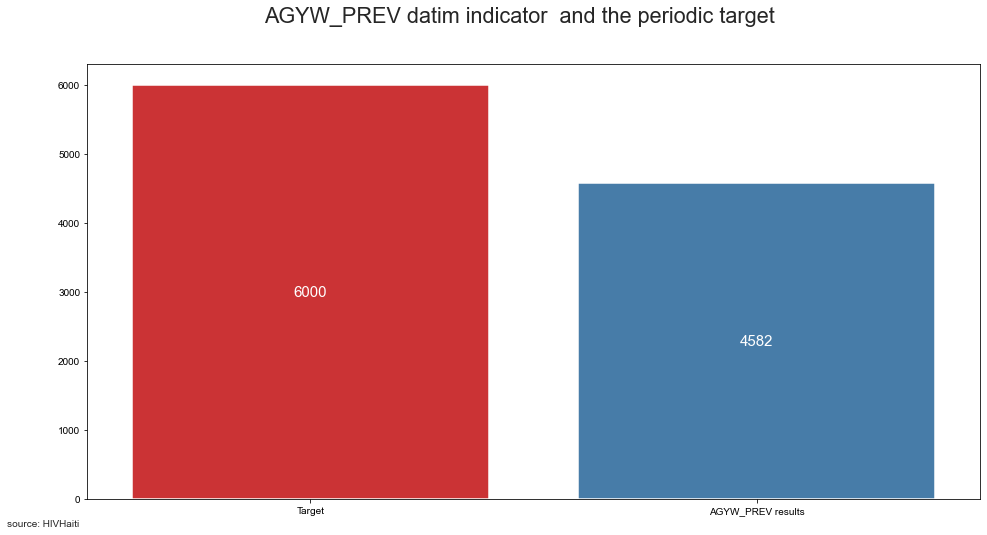

In [11]:



datim.total_datim_general
target= 6000

data_plot = DataFrame({"state":["Target","AGYW_PREV results"],
                            "data": [target,datim.total_datim_general]                        
})


plt.subplots(figsize=(16,8))
sns.set_theme(style="whitegrid", context="talk")
sns.set_style("darkgrid")
sns.set_palette('Set1')
splot = sns.barplot(x="state",y="data",data=data_plot)
splot.set_xlabel("")
splot.set_ylabel("")
plt.suptitle("AGYW_PREV datim indicator  and the periodic target")
for p in splot.patches:
    height = p.get_height()
    plt.text(
                p.get_x() + p.get_width()/2, 
                0.5*p.get_height() + p.get_y(),
                '{:1.0f}'.format(height), 
                ha='center', va='center',
                size=15,
                fontdict=dict(color="white",fontsize=15)
            )
    
plt.annotate(
    "source: HIVHaiti",(0,0), (-80,-20), fontsize=10, 
             xycoords='axes fraction', textcoords='offset points', va='top'
)
plt.savefig("agyw_prev_evolution",dpi=1000)

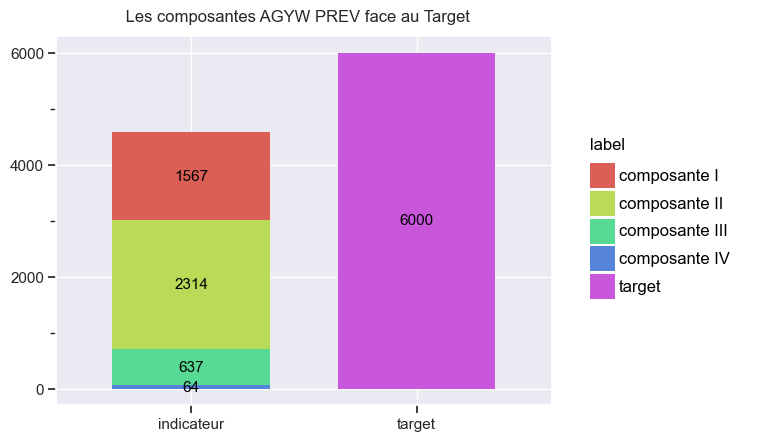

<ggplot: (314278470)>

/usr/local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: composante_agywprev.png


In [12]:
stack_data = DataFrame( 
                  {     
                        "supp":["target","indicateur","indicateur","indicateur",'indicateur'],
                        "label": ["target","composante I","composante II","composante III", 'composante IV'],
                        "data": [target,datim.total_datimI,
                                datim.total_datimII,
                                datim.total_datimIII,datim.total_datimIV]
})

p = (ggplot(stack_data,aes(x="supp",y="data",fill="label",width=0.7)) 
 + geom_bar(position=position_stack(vjust=0.5),stat="identity")
 + geom_text(aes(label="data"),position=position_stack(vjust=0.5))
 + ggtitle(" Les composantes AGYW PREV face au Target")
 + xlab("")
 +ylab("")
 +labs(caption =  "HIVHaiti")
 + theme_seaborn()
)
p
ggsave(plot=p,filename="composante_agywprev.png",dpi=1000)